# Look at changes in clapping rates by location

This notebook visualises the median clapping rate for members of an audience. Hypothesis: people who are near each other converge in clapping rate faster than those who are not. 

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.spatial.distance import pdist, squareform
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import imageio


In [2]:
# import activity analysis functions from aa.py file in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport aa

In [3]:
%reload_ext autoreload

In [4]:
# Now to map those values to locations, need to import some details.
# these are old ID codes, need to replace. 
general_loc = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/'

internal_mlmotion = general_loc + 'Internal/Motion_ML/'
internal_ax3 = general_loc +  'Internal/Motion_AX3/'
internal_Part = general_loc + 'Internal/Participants/'
internal_time = general_loc + 'Internal/Timing/'

public_mlmotion = general_loc + 'Public/Motion_ML/'
public_ax3 = general_loc +  'Public/Motion_AX3/'
public_Part = general_loc + 'Public/Participants/'
public_time = general_loc + 'Public/Timing/'

In [5]:
partDets = pd.read_csv(internal_Part + 'Audience_Mapping_Internal.csv')#,index_col = 0,header_col = 0)
# need only in person participants so cut to those in attendence with seats assinged
partDets = partDets.loc[~partDets['X'].isna(),:]
MovingParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements

Part_Codes = list(MovingParts.Participant_Code.values)


In [6]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(Part_Codes),:].reset_index(drop = True)
Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship
0,ADQ001,ADQ006,3.0,0,Stranger
1,ADQ001,ADQ021,3.0,0,Stranger
2,ADQ001,ADQ023,-2.0,0,Stranger
3,ADQ001,ADQ024,2.0,0,Stranger
4,ADQ001,ADQ031,-2.0,0,Stranger
...,...,...,...,...,...
565,AEQ082,AEQ083,3.0,0,Stranger
566,AEQ082,AEQ087,3.0,0,Stranger
567,AEQ083,AEQ089,3.0,1,Family_ParentChild
568,AEQ084,AER090,3.0,1,Family_ParentChild


## Load a clapping section
individual claps 

In [7]:
claps_folder = 'C:/Users/finnu/dev/copenhagen-musiclab-clapping/clapfiles/clapping_peaks/'
Clap_files = os.listdir(claps_folder)
clapname = Clap_files[14]
# 6 finale, 14 schnittke, 1 beethoven, 0 bach
clapname

'schnittke_applause_peaks.csv'

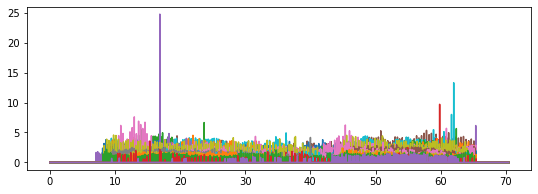

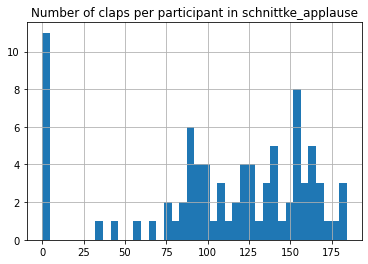

[85, 0.8705882352941177]


In [8]:
# read file
peaks = pd.read_csv(claps_folder + clapname,index_col=0)
exp_name = clapname[:-10]
peaks = peaks.fillna(0)
ts = pd.Series(np.arange(0,len(peaks))*0.02)
t_end = ts.iloc[-1]

df_claps = pd.DataFrame(index = ts,data = peaks.values,columns = peaks.columns)
df_claps.plot(figsize = [2+t_end/10,3],legend = False)
plt.show()
df_OnlyClaps = df_claps.astype(bool).astype(int)
df_OnlyClaps.sum().hist(bins = 40)
plt.title('Number of claps per participant in ' + exp_name)
plt.show()

a = df_OnlyClaps.sum().index
print([len(a),len(a[df_OnlyClaps.sum()>0])/len(a)])
df_claps = df_claps.loc[:,a[df_OnlyClaps.sum()>0]]
#df_claps.columns = range(df_claps.columns.size)
df_OnlyClaps = df_claps.astype(bool).astype(int)
# Evaluate length or recording 

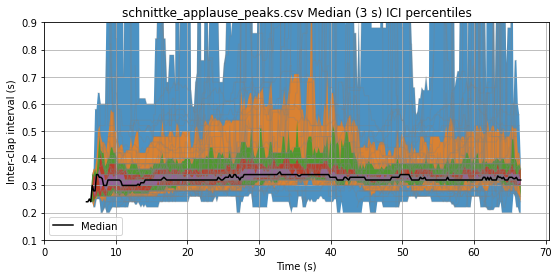

In [9]:
if t_end>15:
    # evaluate clapp statistics
    t_interval = 1.5
    sampletimes = np.arange(0+t_interval,t_end-t_interval,0.2)
    Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)
    Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

    for samp in range(len(sampletimes)):
        t_0 = sampletimes[samp]
        sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
        clap_stats = []
        cols = sub_claps.columns
        these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
        for partn in cols:
            ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
            if ici.notna().sum()>0:
                these_claps[partn]=np.nanmedian(ici)
        Clap_Feats.loc[t_0] = these_claps
    # plot statistics
    df_A = Clap_Feats.copy()
    df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','Midrange','NotNa_C','NotNa_p'])
    df_spans = pd.DataFrame(index = df_A.index,columns = ['Upper','Lower'])
    t_interval = 3
    cntiles = np.array([0,0.1,0.2,0.3,0.4])
    for i, row in df_A.iterrows():
        sub_row = row[row.notna()]
        if len(sub_row)>0:
            these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                           'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
            df_feats.loc[i,:] = these_stats
    df_feats = df_feats.dropna()

    fig,ax = plt.subplots(1,1,figsize=[2+t_end/10,4])
    df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
    #ax.line(df_A.index,df_A)
    df_feats.plot(y='Median',color="black", ax=ax)

    for pc in cntiles:
        for i, row in df_A.iterrows():
            sub_row = row[row.notna()]
            if len(sub_row)>0:
                these_stats = {'Lower':sub_row.quantile(q=pc,interpolation='nearest'),'Upper':sub_row.quantile(q=1-pc,interpolation='nearest')}
                df_spans.loc[i,:] = these_stats
        df_spans = df_spans.dropna()

        x = np.array(df_spans.index)
        y1 = np.array(df_spans.Lower,dtype=np.float32)
        y2 = np.array(df_spans.Upper,dtype=np.float32)
        ax.fill_between(x,y1,y2,alpha = 0.8)

    plt.ylim([0.1,0.9])
    plt.xlim([0,t_end])
    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Inter-clap interval (s)')
    plt.title(clapname +' Median (3 s) ICI percentiles')
    plt.savefig(clapname+'_Applause_Local_ICI_medians_CentileTS.png',dpi=400)
    plt.show()

In [10]:
ClapDets=partDets.loc[partDets['Participant_Code'].isin(Clap_Feats.columns),:]
#Clap_Feats = Clap_Feats[ClapDets['Participant_Code']]
Clap_Feats.fillna(0,inplace = True)
Clap_Feats

,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,ADQ011,ADQ012,...,AEQ080,AEQ081,AEQ082,AEQ083,AEQ084,AEQ085,AEQ087,AEQ088,AEQ089,AER090
1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


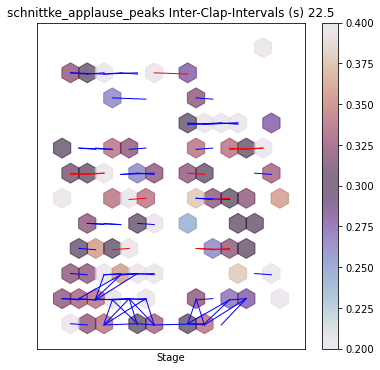

In [11]:
i = 105
plt.figure(figsize=[6,6])
plt.scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[i,:].values, cmap='twilight', vmin=0.2, vmax=0.4, s=400, marker="h", alpha=0.6)
plt.xlim([-8,8])
plt.ylim([0,13])
plt.xticks([])
plt.yticks([])
plt.xlabel('Stage')
plt.title(clapname[:-4] + ' Inter-Clap-Intervals (s) ' + str(np.round(Clap_Feats.iloc[i,:].name,2)))
cbar = plt.colorbar()

# now add the relationships Friends
Friends = Near_Rels[Near_Rels['Relationship'].str.contains('Friend')]
Friends
for i,ship in Friends.iterrows():
    P1 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_1'],:]
    P2 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_2'],:] 
    plt.plot(np.array([P1['Y'],P2['Y']]),np.array([P1['X']-0.05,P2['X']]),'b',linewidth = 1)

Family = Near_Rels[Near_Rels['Relationship'].str.contains('Family')]
Family
for i,ship in Family.iterrows():
    P1 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_1'],:]
    P2 = partDets.loc[partDets['Participant_Code'] == ship['Participant_Code_2'],:]
    plt.plot(np.array([P1['Y'],P2['Y']]),np.array([P1['X']-0.05,P2['X']]),'r',linewidth = 1)


# cbar.solids.set_edgecolor("face")
# plt.draw()
# show the graph
#plt.savefig('./plots/Audience_Devices.png',dpi = 300)
plt.show()

In [12]:
# generate gif with this 
filenames = []
for i in range(len(Clap_Feats)):
    # plot the line chart
    plt.figure(figsize=[6,6])
    plt.scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[i,:].values,  cmap='twilight', vmin=0.2, vmax=0.5, s=400, marker="h", alpha=0.6)
    plt.xlim([-8,8])
    plt.ylim([0,13])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Stage')
    plt.title(clapname[:-4] + ' Inter-Clap-Intervals (s) ' + str(np.round(Clap_Feats.iloc[i,:].name,2)))
    cbar = plt.colorbar()
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()
# extend the last image before looping
filenames.append(filename)
filenames.append(filename)
filenames.append(filename)
filenames.append(filename)
# build gif
gif_path = './plots/Clapping_'+clapname[:-4]+'_ICI_5hz.gif'
with imageio.get_writer(gif_path, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

# TODO

- Look at pairwise local ICI medians for all relationships (spatial, social)

In [25]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Part_Codes = Clap_Feats.columns
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(Part_Codes),:].reset_index(drop = True)
Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship
0,ADQ003,ADQ004,2.0,0,Stranger
1,ADQ003,ADQ010,1.0,1,Family_ParentChild
2,ADQ003,ADQ016,3.0,0,Stranger
3,ADQ003,ADQ018,3.0,0,Stranger
4,ADQ003,ADQ030,3.0,0,Stranger
...,...,...,...,...,...
424,AEQ082,AEQ083,3.0,0,Stranger
425,AEQ082,AEQ087,3.0,0,Stranger
426,AEQ083,AEQ089,3.0,1,Family_ParentChild
427,AEQ084,AER090,3.0,1,Family_ParentChild


<AxesSubplot:>

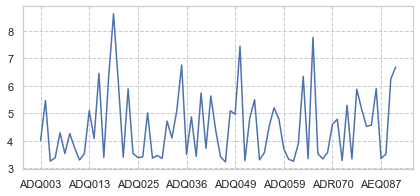

In [49]:
# Euclidian distance metric
A = pd.DataFrame(squareform(pdist(Clap_Feats.T)), columns = Clap_Feats.columns, index = Clap_Feats.columns)
A.median().plot()

In [50]:
Sub_Rels['Seg_Dist'] = 0
Sub_Rels.loc[Sub_Rels['Distance'] == -2.0,'Distance'] = 2.0

for i,row in Sub_Rels.iterrows():
    Sub_Rels.loc[i,'Seg_Dist'] = A[row['Participant_Code_1']][row['Participant_Code_2']]

In [51]:
pg.anova(dv="Seg_Dist",between = ["Distance","Familiarity"], data=Sub_Rels)

,Source,SS,DF,MS,F,p-unc,np2
0,Distance,0.068360,2.0,0.034180,0.009222,0.990821,0.000044
1,Familiarity,1.680131,1.0,1.680131,0.453299,0.501140,0.001070
2,Distance * Familiarity,2.214013,2.0,1.107006,0.298670,0.741960,0.001410
3,Residual,1567.828451,423.0,3.706450,NaN,NaN,NaN


In [52]:
A

,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,ADQ011,ADQ012,...,AEQ080,AEQ081,AEQ082,AEQ083,AEQ084,AEQ085,AEQ087,AEQ088,AEQ089,AER090
ADQ003,0.000000,5.855809,3.625493,4.038936,4.261455,3.565600,2.969377,3.153125,3.168801,3.569328,...,3.262208,6.530819,5.767235,4.445155,4.209549,6.815504,2.298151,3.667820,7.561766,7.039276
ADQ004,5.855809,0.000000,4.563540,4.707175,5.611301,4.812193,5.796456,5.417315,5.105017,4.991473,...,5.098657,7.133548,6.283685,5.839786,6.211103,6.457941,5.349374,4.862571,7.020897,7.401520
ADQ005,3.625493,4.563540,0.000000,1.029077,3.543191,1.548322,3.972984,2.975298,1.878696,2.024673,...,1.689083,5.406404,4.165501,3.829386,4.199560,5.206390,2.530040,1.360184,5.392801,6.034567
ADQ006,4.038936,4.707175,1.029077,0.000000,3.660847,1.826883,4.471689,3.187350,2.153811,2.069662,...,1.887326,5.485745,4.103608,3.866782,4.399670,5.077076,2.899052,1.510132,5.140477,5.996266
ADQ007,4.261455,5.611301,3.543191,3.660847,0.000000,3.713556,4.682841,3.715992,3.872996,3.353610,...,3.758936,5.743135,5.251704,4.842727,5.154231,6.177273,3.498814,3.909565,6.317745,7.058923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AEQ085,6.815504,6.457941,5.206390,5.077076,6.177273,5.576217,7.193212,5.895685,5.972236,5.741185,...,5.736837,7.368643,6.989886,6.007354,7.156452,0.000000,6.316486,5.515451,6.353361,7.883774
AEQ087,2.298151,5.349374,2.530040,2.899052,3.498814,2.812543,2.965586,2.787059,2.233249,2.228991,...,2.255593,5.510181,4.976334,4.229267,4.279673,6.316486,0.000000,2.852297,6.640392,6.588437
AEQ088,3.667820,4.862571,1.360184,1.510132,3.909565,1.322498,4.162776,3.352626,2.302043,2.633249,...,2.048536,5.575688,4.248894,3.895780,4.313931,5.515451,2.852297,0.000000,5.602285,6.115742
AEQ089,7.561766,7.020897,5.392801,5.140477,6.317745,5.775188,7.420330,6.261254,6.001233,5.824654,...,5.751443,6.584322,6.237668,6.424508,7.772709,6.353361,6.640392,5.602285,0.000000,8.157543


In [53]:
sns.set(rc={'figure.figsize':(7,3)})
sns.set_style("whitegrid", {
    "ytick.major.size": 1,
    "ytick.minor.size": 0.5,
    'grid.linestyle': '--',
    "xtick.major.size": 1,
    "xtick.minor.size": 0.5,
    'grid.linestyle': '--'
 })

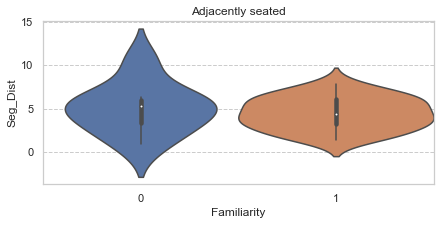

        Source  ddof1  ddof2         F    p-unc       np2
0  Familiarity      1     35  0.527067  0.47267  0.014836


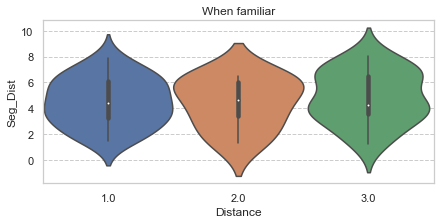

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2     53  0.244842  0.783709  0.009155


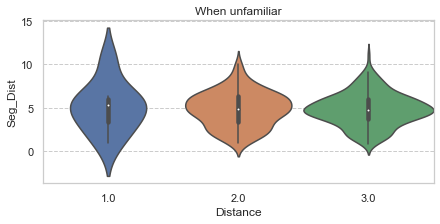

     Source  ddof1  ddof2        F     p-unc       np2
0  Distance      2    370  0.06906  0.933283  0.000373


In [54]:
Sub_Sub_Rels = Sub_Rels[Sub_Rels['Distance'] == 1.0]
sns.violinplot(x = 'Familiarity',y = 'Seg_Dist',width = 1, data = Sub_Sub_Rels)
plt.title('Adjacently seated')
plt.show()
aov = pg.anova(dv="Seg_Dist",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 1]
sns.violinplot(x = 'Distance',y = 'Seg_Dist',width = 1, data = Sub_Sub_Rels)
plt.title('When familiar')
plt.show()
aov = pg.anova(dv="Seg_Dist",between = "Distance", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 0]
sns.violinplot(x = 'Distance',y = 'Seg_Dist',width = 1, data = Sub_Sub_Rels)
plt.title('When unfamiliar')
plt.show()
aov = pg.anova(dv="Seg_Dist",between = "Distance", data=Sub_Sub_Rels)
print(aov)

# looking at larger distances between pairs

In [55]:
# collect all pairwise distances, modefied from nearby
nearby = []
for i,a in partDets.iterrows():
    A = ((partDets.loc[i+1:,'X'] - a['X']).pow(2)+(partDets.loc[i+1:,'Y'] - a['Y']).pow(2)).pow(0.5)
    if len(A)>0:
        neighs = partDets.loc[A.index].index
        Dist = A
        for j in range(len(neighs)):
            c = neighs[j]
            nearby.append([partDets.loc[i].Participant_Code,partDets.loc[c].Participant_Code,Dist.iloc[j]])
len(nearby)    

4095

In [56]:
# file not currently public
rel_folder = general_loc + 'Concert_MusicLab/Participant_details/'
Rels = pd.read_csv(rel_folder + 'Pairwise_Relationship_Hall.csv') 
print(len(Rels))

86


In [57]:
Near_Rels = pd.DataFrame(columns=["Participant_Code_1","Participant_Code_2","Distance","Familiarity","Relationship"])

for i in range(len(nearby)):
    ns = nearby[i]
    Near_Rels.loc[i,"Participant_Code_1"] = ns[0]
    Near_Rels.loc[i,"Participant_Code_2"] = ns[1]


    P1 = partDets.loc[partDets['Participant_Code'] == ns[0],:]
    P2 = partDets.loc[partDets['Participant_Code'] == ns[1],:]
    
#     if P2['X'].values-P1['X'].values<0:
#         distC = -1 # P1 is behind P2
#     else:
#         distC = 1
    
    Near_Rels.loc[i,"Distance"] = np.round(ns[2]) # simplify stratification
#     if ns[2]>=2: # around
#         Near_Rels.loc[i,"Distance"] = 3.0
#     else:
#         if ns[2]>1: # close
#             Near_Rels.loc[i,"Distance"] =  distC * 2.0
#         else: # adjacent
#             Near_Rels.loc[i,"Distance"] = 1.0
    # check if 
    A = Rels.loc[Rels['P1']==P1['Temp_Codes'].values[0]]
    if len(A)<1: 
        A = Rels.loc[Rels['P2']==P1['Temp_Codes'].values[0]]
        R = A.loc[A['P1']==P2['Temp_Codes'].values[0]]
    else:
        R = A.loc[A['P2']==P2['Temp_Codes'].values[0]]
        if len(R)<1: # check the alternate order, just in case
            A = Rels.loc[Rels['P2']==P1['Temp_Codes'].values[0]]
            R = A.loc[A['P1']==P2['Temp_Codes'].values[0]]

    if len(R)>0: # these two knew each other
        Near_Rels.loc[i,"Familiarity"] = 1 
        Near_Rels.loc[i,"Relationship"] = R.Relationship.values[0]
    else:
        Near_Rels.loc[i,"Familiarity"] = 0 
        Near_Rels.loc[i,"Relationship"] = 'Stranger'

Near_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship
0,ADQ001,ADQ002,6.0,0,Stranger
1,ADQ001,ADQ003,6.0,0,Stranger
2,ADQ001,ADQ004,5.0,0,Stranger
3,ADQ001,ADQ005,6.0,0,Stranger
4,ADQ001,ADQ006,2.0,0,Stranger
...,...,...,...,...,...
4090,AEQ088,AER090,10.0,0,Stranger
4091,AEQ088,AEU091,12.0,0,Stranger
4092,AEQ089,AER090,10.0,0,Stranger
4093,AEQ089,AEU091,9.0,0,Stranger


In [58]:
# reduce to list of relationships included in the dataset available here
Part_Codes = Clap_Feats.columns
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(Part_Codes),:].reset_index(drop = True)
len(Sub_Rels)

2701

<AxesSubplot:>

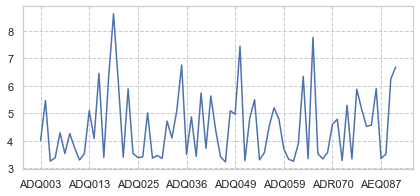

In [59]:
# Euclidian distance metric
A = pd.DataFrame(squareform(pdist(Clap_Feats.T)), columns = Clap_Feats.columns, index = Clap_Feats.columns)
A.median().plot()

In [62]:
Sub_Rels['Seg_Dist'] = 0

for i,row in Sub_Rels.iterrows():
    Sub_Rels.loc[i,'Seg_Dist'] = A[row['Participant_Code_1']][row['Participant_Code_2']]

In [63]:
pg.anova(dv="Seg_Dist",between = ["Distance","Familiarity"], data=Sub_Rels)

C:\Users\finnu\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 4
  warnings.warn('covariance of constraints does not have full '


,Source,SS,DF,MS,F,p-unc,np2
0,Distance,3704.581470,15.0,246.972098,63.778746,1.419173e-51,0.262992
1,Familiarity,388.064688,1.0,388.064688,100.214880,3.472540e-23,0.036033
2,Distance * Familiarity,273.084442,15.0,18.205629,4.701471,4.891155e-09,0.025630
3,Residual,10381.706028,2681.0,3.872326,NaN,NaN,NaN


In [67]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [68]:
data = sm.datasets.get_rdataset('dietox', 'geepack').data

In [69]:
data

,Pig,Evit,Cu,Litter,Start,Weight,Feed,Time
0,4601,Evit000,Cu000,1,26.5,26.50000,NaN,1
1,4601,Evit000,Cu000,1,26.5,27.59999,5.200005,2
2,4601,Evit000,Cu000,1,26.5,36.50000,17.600000,3
3,4601,Evit000,Cu000,1,26.5,40.29999,28.500000,4
4,4601,Evit000,Cu000,1,26.5,49.09998,45.200001,5
...,...,...,...,...,...,...,...,...
856,8442,Evit000,Cu175,24,25.7,73.19995,83.800003,8
857,8442,Evit000,Cu175,24,25.7,81.69995,99.800003,9
858,8442,Evit000,Cu175,24,25.7,90.29999,115.200001,10
859,8442,Evit000,Cu175,24,25.7,96.00000,133.200001,11


In [71]:
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"], re_formula="~Time")
md

In [76]:
md = smf.mixedlm("Seg_Dist ~ Distance", Sub_Rels, groups=Sub_Rels["Familiarity"], re_formula="~Distance")
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

C:\Users\finnu\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                        Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           Seg_Dist  
No. Observations:           2701              Method:                       REML      
No. Groups:                 2                 Scale:                        3.8676    
Min. group size:            57                Log-Likelihood:               -5662.4824
Max. group size:            2644              Converged:                    Yes       
Mean group size:            1350.5                                                    
--------------------------------------------------------------------------------------
                                        Coef.    Std.Err.     z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                4.757        0.226 21.068 0.000  4.315  5.200
Distance[T.2.0]                          0.050                      

C:\Users\finnu\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\finnu\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2711: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


In [70]:
Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship,Seg_Dist,Seg_Corr
0,ADQ003,ADQ004,2.0,0,Stranger,5.855809,5.855809
1,ADQ003,ADQ005,4.0,0,Stranger,3.625493,3.625493
2,ADQ003,ADQ006,4.0,0,Stranger,4.038936,4.038936
3,ADQ003,ADQ007,7.0,0,Stranger,4.261455,4.261455
4,ADQ003,ADQ008,10.0,0,Stranger,3.565600,3.565600
...,...,...,...,...,...,...,...
2696,AEQ087,AEQ089,8.0,0,Stranger,6.640392,6.640392
2697,AEQ087,AER090,2.0,0,Stranger,6.588437,6.588437
2698,AEQ088,AEQ089,6.0,0,Stranger,5.602285,5.602285
2699,AEQ088,AER090,10.0,0,Stranger,6.115742,6.115742


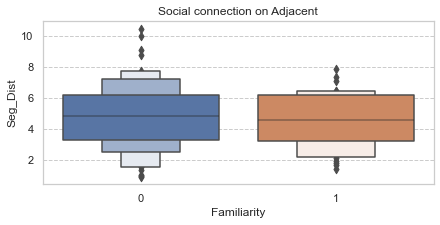

        Source  ddof1  ddof2         F     p-unc      np2
0  Familiarity      1   2699  0.622007  0.430372  0.00023


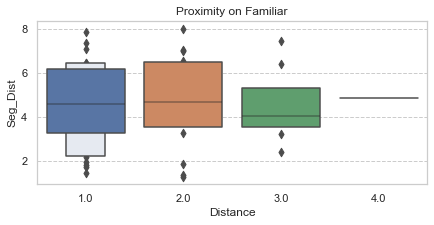

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      3     53  0.061861  0.979661  0.003489


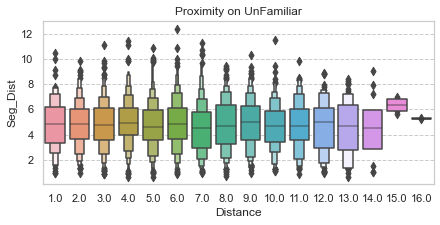

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance     15   2628  0.931548  0.527757  0.005289


In [64]:
#sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
#sns.set_theme(style="whitegrid")
Sub_Sub_Rels = Sub_Rels[Sub_Rels['Distance'] == 1.0]
sns.boxenplot(x = 'Familiarity',y = 'Seg_Dist', data = Sub_Sub_Rels)
plt.title('Social connection on Adjacent')
# plt.savefig('plots/PairCorr_allEvents_Familiarity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_Dist",between = "Familiarity", data=Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 1.0]
sns.boxenplot(x = 'Distance',y = 'Seg_Dist', data = Sub_Sub_Rels)
plt.title('Proximity on Familiar')
# plt.savefig('plots/PairCorr_allEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_Dist",between = "Distance", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 0.0]
sns.boxenplot(x = 'Distance',y = 'Seg_Dist', data = Sub_Sub_Rels)
plt.title('Proximity on UnFamiliar')
# plt.savefig('plots/PairCorr_allEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_Dist",between = "Distance", data=Sub_Sub_Rels)
print(aov)


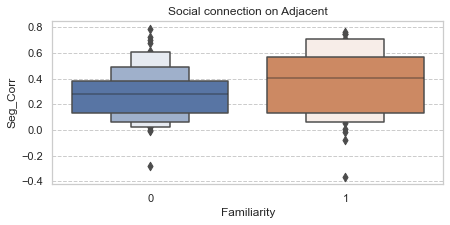

        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1   2626  1.808823  0.178766  0.000688


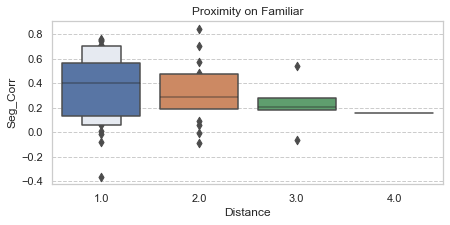

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      3     53  0.506311  0.679605  0.027861


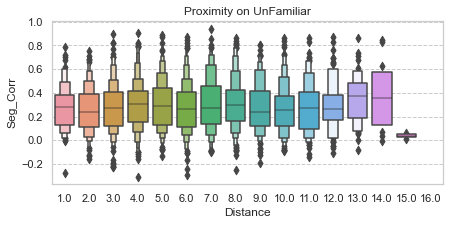

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance     14   2556  1.684945  0.052087  0.009145


In [64]:
#sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
#sns.set_theme(style="whitegrid")
Sub_Sub_Rels = Sub_Rels[Sub_Rels['Distance'] == 1.0]
sns.boxenplot(x = 'Familiarity',y = 'Seg_Corr', data = Sub_Sub_Rels)
plt.title('Social connection on Adjacent')
# plt.savefig('plots/PairCorr_allEvents_Familiarity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Familiarity", data=Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 1.0]
sns.boxenplot(x = 'Distance',y = 'Seg_Corr', data = Sub_Sub_Rels)
plt.title('Proximity on Familiar')
# plt.savefig('plots/PairCorr_allEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 0.0]
sns.boxenplot(x = 'Distance',y = 'Seg_Corr', data = Sub_Sub_Rels)
plt.title('Proximity on UnFamiliar')
# plt.savefig('plots/PairCorr_allEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)


In [61]:
Sub_Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship,Seg_Corr
19,ADQ001,ADQ023,1.0,0,Stranger,0.227204
46,ADQ001,ADQ052,1.0,0,Stranger,0.002606
79,ADQ002,ADQ009,1.0,0,Stranger,0.503365
82,ADQ002,ADQ012,1.0,0,Stranger,0.317408
89,ADQ002,ADQ019,1.0,0,Stranger,0.378706
...,...,...,...,...,...,...
2627,ADR069,AEQ081,1.0,0,Stranger,0.062604
2628,ADR069,AEQ082,1.0,0,Stranger,0.394730
2664,AEQ079,AER090,1.0,1,Family_Partner,0.126859
2671,AEQ080,AEQ089,1.0,1,Family_ParentChild,0.094742
